## Part 1: Multi-Armed bandits

As discussed in Lecture 1, the $k$-armed bandit problem is a classic learning problem that well demonstrates the dilemma between exploration and exploitation when making decisions.

In this seminar, our goal is to implement and evaluate the performance of the $\varepsilon$-greedy algorithm, the UCB algorithm and the Thompson sampling algorithm for the four Bernoulli arms example covered in the lecture.

![Four arms](./graphs/fourarms.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

# you might see an error that the module "tkinter" is not installed. If on Mac Os you can install it through the terminal via "brew install python-tk@3.9". General help can as always be found on stackoverflow: "https://stackoverflow.com/questions/25905540/importerror-no-module-named-tkinter" 

np.random.seed(10)

bandit_probabilities = [0.10, 0.40, 0.10, 0.10]

number_of_bandits = len(bandit_probabilities) # = n_actions
    
action_space = np.arange(number_of_bandits) # =[0,1,2,3]

number_of_trials = 20 
timesteps = 1000

arms = np.zeros(timesteps, dtype=int)

def step(action):
    rand = np.random.random()  # [0.0,1.0)
    reward = 1.0 if (rand < bandit_probabilities[action]) else 0.0
    return reward

def compute_regret(bandit_probabilities, arms, time_steps):
    probs = [bandit_probabilities[arm] for arm in arms]
    return np.cumsum(np.ones(time_steps)) * np.amax(bandit_probabilities) - np.cumsum(probs)


def cumulative_average_mean(r, n):
    return np.cumsum(r) / np.cumsum(np.ones(n))


def plot_rewards(reward_list, n):
    for r in reward_list:
        plt.plot(cumulative_average_mean(r[0], n), linewidth=3)
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    legend_str = [r[1] for r in reward_list]
    plt.legend(legend_str)
    plt.show()

def plot_regrets(regrets):
    for a in regrets:
        plt.plot(a[0], linewidth=3)
    plt.xlabel('Steps')
    plt.ylim(0.0,50.0)
    plt.ylabel('Regret')
    legend_str = [r[1] for r in regrets]
    plt.legend(legend_str)
    plt.show()




### Additional background for regret and stochastic multi-arm bandits**

Recall that the $\epsilon$-greedy algorithm at each decision time makes a greedy choice with probability $\epsilon$, and, otherwise, makes an explorative step by selecting an arm uniformly at random from the set of all arms. We have discussed in the lecture how adding such an explorative step can outperform a greedy algorithm (that always makes greedy choices) with respect to different performance metrics. In particular, we considered the regret defined as follows  

$$\mathrm{Regret}(T)=Q(a^*)T-\sum_{t=1}^TQ(a_t)$$

where $Q(a)$ is the expected reward of arm $a$, $a^*$ is a best arm, and $a_t$ is the arm selected by the algorithm at time step $t$.

The $\epsilon$-greedy algorithm has a regret that linearly increases with time $T$. This is easy to observe as follows. Let $d$ be a positive parameter such that $Q(a^*)-Q(a) \le d$ for all $a$ such that $Q(a)<Q(a^*)$. We call any arm $a$ such that $Q(a)<Q(a^*)$ a non-best arm. Then, we can readily observe that the following relation holds

$$\mathrm{Regret}(T)\geq{d{M_T}}$$

where $M_T$ is the number of times a non-best arm is selected by the algorithm. 

Now, for the $\varepsilon$-greedy algorithm, at each time step, a non-best arm is pulled with probability at least $\epsilon/k$, which combined with the law of large numbers yields 

$$\lim_{T\rightarrow\infty}M_T/T\geq\epsilon/k$$ 

Therefore, it follows

$$\mathrm{Regret}(T)\ge d\epsilon T/k$$ 

with high probability.

#### The following code implements the $\epsilon$-greedy policy

In [3]:
def epsilon_greedy_policy(epsilon, actions, q_values):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(q_values) if value_ == np.max(q_values)])
    
def apply_epsilon_greedy(n_bandits, action_space, n_trials, timesteps, epsilons, arms):
    rewards = np.zeros((len(epsilons), n_trials, timesteps), dtype=float)
    regrets = np.zeros((len(epsilons), n_trials, timesteps), dtype=float)

    for eps_counter, eps in enumerate(epsilons):
        for trial in range(n_trials):
            n = np.zeros(n_bandits, dtype=int)
            q = np.zeros(n_bandits, dtype=float)
            for t in range(timesteps):
                action = epsilon_greedy_policy(eps, action_space, q)

                r = step(action)

                # updating action counter and Q
                n[action] += 1
                q[action] = q[action] + 1.0 / (n[action] + 1) * (r - q[action])

                rewards[eps_counter, trial, t] += r
                arms[t] = action

            regret = compute_regret(bandit_probabilities, arms, timesteps)
            regrets[eps_counter, trial, :] += regret

    rewards = np.mean(rewards, axis=1)
    regrets = np.mean(regrets, axis=1)

    rewards = list(rewards) 
    regrets = list(regrets)
    
    legend_entries = ["$\epsilon$-greedy $\epsilon=" + str(eps) + "$" for eps in epsilons] 

    rewards = list(zip(rewards, legend_entries))
    regrets = list(zip(regrets, legend_entries))


    return rewards,regrets

In [4]:
epsilons = [0.0, 0.01, 0.1]
rewards_epsilon_greedy, regrets_epsilon_greedy = apply_epsilon_greedy(number_of_bandits, 
                                                                      action_space, 
                                                                      number_of_trials, 
                                                                      timesteps, 
                                                                      epsilons, 
                                                                      arms)

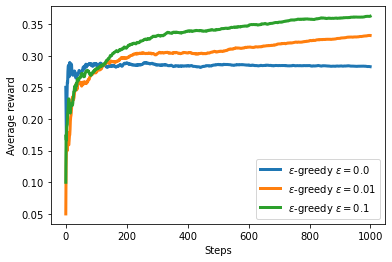

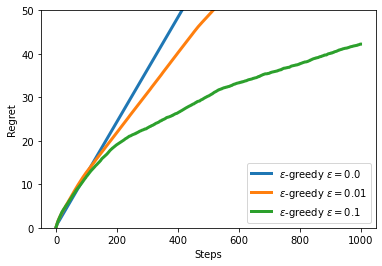

In [5]:
plot_rewards(rewards_epsilon_greedy, timesteps)
plot_regrets(regrets_epsilon_greedy)

### Policies with sublinear regret

We have seen policies in the lecture that improve on linear regrets. It is well known that for stochastic multi-armed bandit problems the optimal growth of the regret is logarithmic in $T$. We have in the lecture learned about Upper Confidence Bound which achieve this optimal regret bound.

![UCB](./graphs/ucb_lecture.png)

![UCB1](./graphs/UCBalg.png)

In [6]:
ucb_constants = [0.1,1.0,10.0]

In [7]:
def upper_confidence_bound_policy(c, actions, q_values, iteration, num_invocations):
    upper_confidence_bounds = [q_values[action] + c * np.sqrt(np.log(iteration + 1) / (num_invocations[action])) if num_invocations[action] > 0 else np.inf for action in actions]
    return np.random.choice([action_ for action_, value_ in enumerate(upper_confidence_bounds) if value_ == np.max(upper_confidence_bounds)])

def apply_upper_confidence_bound_policy(n_bandits, action_space, n_trials, timesteps, arms, ucb_constants):
    # For different upper confidence bounds constants
    rewards = np.zeros((len(ucb_constants), n_trials, timesteps), dtype=float)
    regrets = np.zeros((len(ucb_constants), n_trials, timesteps), dtype=float)

    for ucb_constant_counter, ucb_constant in enumerate(ucb_constants):
        for trial in range(n_trials):
            n = np.zeros(n_bandits, dtype=int)
            q = np.zeros(n_bandits, dtype=float)

            for t in range(timesteps):
                
                action = upper_confidence_bound_policy(ucb_constant, action_space, q, t, n)

                r = step(action)

                # updating action counter and expected reward Q
                n[action] += 1
                q[action] = q[action] + 1.0 / (n[action] + 1) * (r - q[action])
                
                rewards[ucb_constant_counter, trial, t] += r
                arms[t] = action

            regret = compute_regret(bandit_probabilities, arms, timesteps)
            regrets[ucb_constant_counter, trial, :] += regret

    rewards = np.mean(rewards, axis=1)
    regrets = np.mean(regrets, axis=1)

    rewards = list(rewards) 
    regrets = list(regrets)
    
    legend_entries = ["UCB $c=" + str(ucb_constant) + "$" for ucb_constant in ucb_constants] 

    rewards = list(zip(rewards, legend_entries))
    regrets = list(zip(regrets, legend_entries))

    return rewards,regrets


rewards_ucb, regrets_ucb = apply_upper_confidence_bound_policy(number_of_bandits, action_space, number_of_trials, timesteps, arms, ucb_constants)


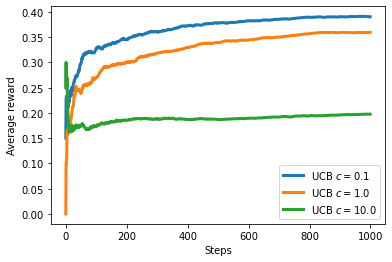

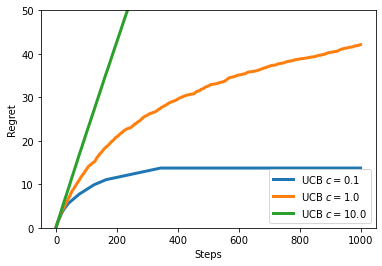

In [8]:
plot_rewards(rewards_ucb, timesteps)
plot_regrets(regrets_ucb)

### Thompson Sampling

![thompson](./graphs/thompson_sampling_lecture.png)

In [9]:
alpha_beta_priors = [[1.0,1.0], [1.0, 5.0], [1.0, 10.0]]
    
def apply_thompson_sampling_policy(n_bandits, action_space, n_trials, timesteps, arms, alpha_beta_priors):
    # For different upper confidence bounds constants
    rewards = np.zeros((len(alpha_beta_priors), n_trials, timesteps), dtype=float)
    regrets = np.zeros((len(alpha_beta_priors), n_trials, timesteps), dtype=float)

    for prior_counter, alpha_beta_prior in enumerate(alpha_beta_priors):
        for trial in range(n_trials):
            alpha = alpha_beta_prior[0]
            beta  = alpha_beta_prior[1]
            successes = np.zeros(n_bandits, int)
            failures = np.zeros(n_bandits, int)
            theta = np.zeros(n_bandits, float)
            n = np.zeros(n_bandits, dtype=int)
            q = np.zeros(n_bandits, dtype=float)

            for t in range(timesteps):

                for bandit in range(n_bandits):
                    theta[bandit] = np.random.beta(successes[bandit] + alpha, failures[bandit] + beta)

                action = np.random.choice([action_ for action_, value_ in enumerate(theta) if value_ == np.max(theta)])

                r = step(action)

                # updating action counter and expected reward Q
                n[action] += 1

                successes[action] += (r == 1)
                failures[action] += (r == 0) 

                rewards[prior_counter, trial, t] += r
                arms[t] = action

            regret = compute_regret(bandit_probabilities, arms, timesteps)
            regrets[prior_counter, trial, :] += regret

    rewards = np.mean(rewards, axis=1)
    regrets = np.mean(regrets, axis=1)

    rewards = list(rewards) 
    regrets = list(regrets)
    
    legend_entries = ["Thompson $\\alpha=" + str(alpha_beta[0]) + ", \\beta=" + str(alpha_beta[1]) + "$" for alpha_beta in alpha_beta_priors] 

    rewards = list(zip(rewards, legend_entries))
    regrets = list(zip(regrets, legend_entries))

    return rewards,regrets


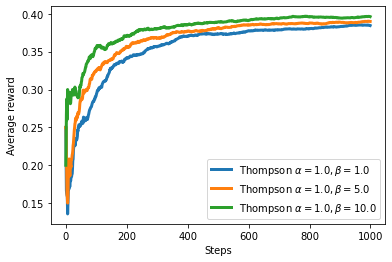

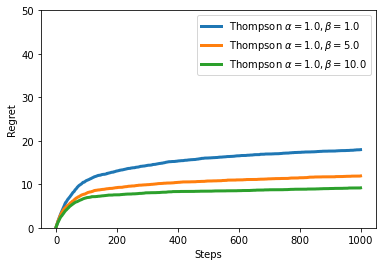

In [10]:
rewards_thompson, regrets_thompson = apply_thompson_sampling_policy(number_of_bandits, 
                                                                    action_space, 
                                                                    number_of_trials, 
                                                                    timesteps, 
                                                                    arms, 
                                                                    alpha_beta_priors)

plot_rewards(rewards_thompson, timesteps)
plot_regrets(regrets_thompson)


## Joint plots

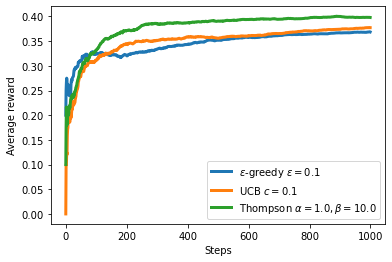

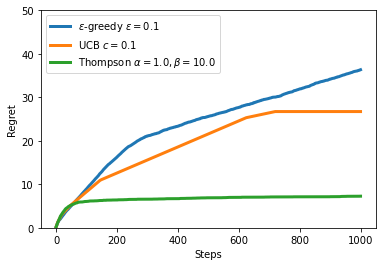

In [11]:
epsilons = [0.1]
rewards_epsilon_greedy, regrets_epsilon_greedy = apply_epsilon_greedy(number_of_bandits, 
                                                                      action_space, 
                                                                      number_of_trials, 
                                                                      timesteps, 
                                                                      epsilons, 
                                                                      arms)

ucb_constants = [0.1]
rewards_ucb, regrets_ucb = apply_upper_confidence_bound_policy(number_of_bandits, action_space, number_of_trials, 
                                                               timesteps, arms, ucb_constants)

alpha_beta_priors = [[1.0, 10.0]]
rewards_thompson, regrets_thompson = apply_thompson_sampling_policy(number_of_bandits, 
                                                                    action_space, 
                                                                    number_of_trials, 
                                                                    timesteps, 
                                                                    arms, 
                                                                    alpha_beta_priors)

reward_list = rewards_epsilon_greedy + rewards_ucb + rewards_thompson
plot_rewards(reward_list, timesteps)

regret_list = regrets_epsilon_greedy + regrets_ucb + regrets_thompson
plot_regrets(regret_list)